In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 29 14:00:37 2015

@author: alexandrebarachant

Beat the benchmark with CSP and Logisitic regression.

General Idea :

The goal of this challenge is to detect events related to hand movements. Hand 
movements are caracterized by change in signal power in the mu (~10Hz) and beta
(~20Hz) frequency band over the sensorimotor cortex. CSP spatial filters are
trained to enhance signal comming from this brain area, instantaneous power is
extracted and smoothed, and then feeded into a logisitic regression.

Preprocessing :

Signal are bandpass-filtered between 7 and 30 Hz to catch most of the signal of
interest. 4 CSP spatial filters are then applied to the signal, resutlting to
4 new time series.  In order to train CSP spatial filters, EEG are epoched 
using a window of 2 second before and after the event 'HandStart'. CSP training
needs two classes. the epochs after Replace event are assumed to contain 
patterns corresponding to hand movement, and epochs before are assumed to 
contain resting state.

Feature extraction :

Preprocessing is applied, spatialy filtered signal are the rectified and 
convolved with a 0.5 second rectangular window for smoothing. Then a logarithm
is applied. the resutl is a vector of dimention 4 for each time sample.

Classification :

For each of the 6 event type, a logistic regression is trained. For training 
only, features are downsampled in oder to speed up the process. Prediction are
the probailities of the logistic regression.

"""

#print(__doc__)

import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from glob import glob

from scipy.signal import butter, lfilter, convolve, boxcar
from joblib import Parallel, delayed

def creat_mne_raw_object(fname,read_events=True,norm=False):
    """Create a mne raw instance from csv file"""
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T # From microvolts to volts
    # this normalizes the data per series.
    if norm:
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
        data = min_max_scaler.fit_transform(data)
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
    
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    info['filename'] = fname
    
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    
    return raw

In [95]:
subjects = range(1,13)

# design a butterworth bandpass filter 
freqs = [7, 30]
b,a = butter(5,np.array(freqs)/250.0,btype='bandpass')

# CSP parameters
# Number of spatial filter to use
nfilters = 4

# convolution
# window for smoothing features
nwin = 250

################################################################################
###### CHANGE THIS FOR SMALLER AMOUNTS OF DATA. SUBSAMPLE = 1 IS ALL DATA.######
# training subsample
subsample = 1
################################################################################
# submission file
#submission_file = 'JATED.csv'
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

for subject in subjects:
    epochs_tot = []
    y = []
    idstr_tot = []
    idste_tot = []
    pred_tot = []
    trainY_tot = []
    trainX_tot = []
    testX_tot = []

    ################ READ DATA ################################################
    fnames =  glob('/Users/eszti/Documents/__NYC_DSA/Dev/capstone_eeg/train/subj%d_series*_data.csv' % (subject))
    
    # read and concatenate all the files
    raw = concatenate_raws([creat_mne_raw_object(fname,norm=True) for fname in fnames])
       
    # pick eeg signal
    picks = pick_types(raw.info,eeg=True)
    
    # Filter data for alpha frequency and beta band
    # Note that MNE implement a zero phase (filtfilt) filtering not compatible
    # with the rule of future data.
    # Here we use left filter compatible with this constraint. 
    ######### parallel version ########
    # The function parallelized for speeding up the script
    #raw._data[picks] = np.array(Parallel(n_jobs=-1)(delayed(lfilter)(b,a,raw._data[i]) for i in picks))
    #########
    raw._data[picks] = lfilter(b,a,raw._data[picks])
    
    ################ CSP Filters training #####################################
    # get event posision corresponding to HandStart
    events = find_events(raw,stim_channel='HandStart', verbose=False)
    # epochs signal for 2 second after the event
    epochs = Epochs(raw, events, {'during' : 1}, 0, 2, proj=False,
                    picks=picks, baseline=None, preload=True,
                    add_eeg_ref=False, verbose=False)
    
    epochs_tot.append(epochs)
    y.extend([1]*len(epochs))
    
    # epochs signal for 2 second before the event, this correspond to the 
    # rest period.
    epochs_rest = Epochs(raw, events, {'before' : 1}, -2, 0, proj=False,
                    picks=picks, baseline=None, preload=True,
                    add_eeg_ref=False, verbose=False)
    
    # Workaround to be able to concatenate epochs with MNE
    epochs_rest.times = epochs.times
    
    y.extend([-1]*len(epochs_rest))
    epochs_tot.append(epochs_rest)
        
    # Concatenate all epochs
    epochs = concatenate_epochs(epochs_tot)
    
    # get data 
    X = epochs.get_data()
    y = np.array(y)
    
    
    # train CSP
    csp = CSP(n_components=nfilters, reg='lws')
    csp.fit(X,y)
    
    ################ Create Training Features #################################
    # apply csp filters and rectify signal
    feat = np.dot(csp.filters_[0:nfilters],raw._data[picks])**2
    
    # smoothing by convolution with a rectangle window    
    ####### parallel version ###########
    #feattr = np.array(Parallel(n_jobs=-1)(delayed(convolve)(feat[i],boxcar(nwin),'full') for i in range(nfilters)))
    #feattr = np.log(feattr[:,0:feat.shape[1]])
    #######
    feattr = np.empty(feat.shape)
    for i in range(nfilters):
        feattr[i] = np.log(convolve(feat[i],boxcar(nwin),'full'))[0:feat.shape[1]]
 
    # training labels
    # they are stored in the 6 last channels of the MNE raw object
    labels = raw._data[32:]
    
    ######### Lists of training data and ids to write csv ########################
    trainY_tot.append(labels[:,::subsample].T)
    trainX_tot.append(feattr[:,::subsample].T)
    idstr = np.concatenate([np.array(pd.read_csv(fname)['id']) for fname in fnames])
    idstr_tot.append(idstr[::subsample])
    
    ################ Create test Features #####################################
    # read test data 
    fnames =  glob('/Users/eszti/Documents/__NYC_DSA/Dev/capstone_eeg/test/subj%d_series*_data.csv' % (subject))
    raw = concatenate_raws([creat_mne_raw_object(fname, read_events=False,norm=True) for fname in fnames])
    test_raw = raw
    ####### parallel version ###########
    #raw._data[picks] = np.array(Parallel(n_jobs=-1)(delayed(lfilter)(b,a,raw._data[i]) for i in picks))
    #######
    raw._data[picks] = lfilter(b,a,raw._data[picks])
    
    # read ids
    idste = np.concatenate([np.array(pd.read_csv(fname)['id']) for fname in fnames])
    idste_tot.append(idste)
    
    # apply preprocessing on test data
    feat = np.dot(csp.filters_[0:nfilters],raw._data[picks])**2
    ####### parallel version ###########
    #featte = np.array(Parallel(n_jobs=-1)(delayed(convolve)(feat[i],boxcar(nwin),'full') for i in range(nfilters)))
    #featte = np.log(featte[:,0:feat.shape[1]])
    #######
    featte = np.empty(feat.shape)
    for i in range(nfilters):
        featte[i] = np.log(convolve(feat[i],boxcar(nwin),'full'))[0:feat.shape[1]]
        
    ######### Data Frames of test data to write csv ########################
    testX_tot.append(featte.T)
    
    ################ Train classifiers ########################################
    #lr = LogisticRegression()
    #pred = np.empty((len(ids),6))
    #for i in range(6):
    #    print('Train subject %d, class %s' % (subject, cols[i]))
    #    lr.fit(feattr[:,::subsample].T,labels[i,::subsample])
    #    pred[:,i] = lr.predict_proba(featte.T)[:,1]
    
    #pred_tot.append(pred)
    trainX = pd.DataFrame(np.concatenate(trainX_tot),np.concatenate(idstr_tot),columns = ['F1','F2','F3','F4'])
    trainY = pd.DataFrame(np.concatenate(trainY_tot),np.concatenate(idstr_tot),columns=cols)
    testX = pd.DataFrame(np.concatenate(testX_tot),np.concatenate(idste_tot),columns = ['F1','F2','F3','F4'])
    train = trainX.join(trainY)
    #for i in range(1,9):
    #    subsetX = trainX[trainX.index.to_series().str.contains('series'+str(i))]
    #    subsetX.to_csv('csp_train/subj'+str(subject)+'_series'+str(i)+'_data.csv')
    #    subsetY = trainY[trainY.index.to_series().str.contains('series'+str(i))]
    #    subsetY.to_csv('csp_train/subj'+str(subject)+'_series'+str(i)+'_events.csv')
    #for i in range(9,11):
    #    subsetTe = testX[testX.index.to_series().str.contains('series'+str(i))]
    #    subsetTe.to_csv('csp_test/subj'+str(subject)+'_series'+str(i)+'_data.csv')
    train.to_csv('Rcsp_train_subj'+str(subject)+'.csv',index_label='id',float_format='%.5f') 
    testX.to_csv('Rcsp_test_subj'+str(subject)+'.csv',index_label='id',float_format='%.5f') 

# create pandas object for train data
#submission = pd.DataFrame(index=np.concatenate(idste_tot),
#                          columns=cols,
#                          data=np.concatenate(pred_tot))

# write file
#submission.to_csv(submission_file,index_label='id',float_format='%.5f')        

In [3]:
# writing csv's after all data from each subject collected
trainY = pd.DataFrame(np.concatenate(trainY_tot),np.concatenate(idstr_tot),columns=cols)
trainX = pd.DataFrame(np.concatenate(trainX_tot),np.concatenate(idstr_tot),columns = ['F1','F2','F3','F4'])
train = trainX.join(trainY)
train.to_csv('csp_train.csv',index_label='id',float_format='%.5f') 
testX = pd.DataFrame(np.concatenate(testX_tot),np.concatenate(idste_tot),columns = ['F1','F2','F3','F4'])
testX.to_csv('csp_testX.csv',index_label='id',float_format='%.5f') 

In [40]:
len(testX)

3144171

In [9]:
csp_accompanied = train[train.iloc[:,4:10].sum(axis=1)>1]

In [12]:
csp_accompanied.to_csv('csp_accompanied.csv',float_format = '%.5f')

In [14]:
csp_solo = train[train.iloc[:,4:10].sum(axis=1)<2]
csp_solo.shape

(17506815, 10)

In [15]:
csp_solo.to_csv('csp_solo.csv',float_format = '%.5f')

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

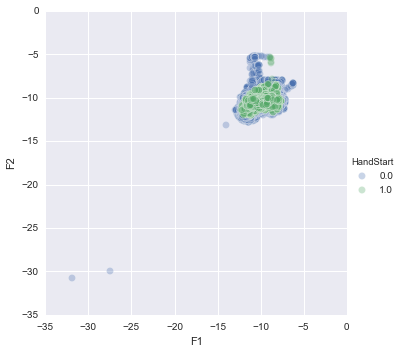

In [44]:
#pal = dict(0="seagreen", 1="gray")
g = sns.FacetGrid(train, hue="HandStart", size=5)
g.map(plt.scatter, "F1", "F2", s=50, alpha=.3, linewidth=.5, edgecolor="white")
g.add_legend();

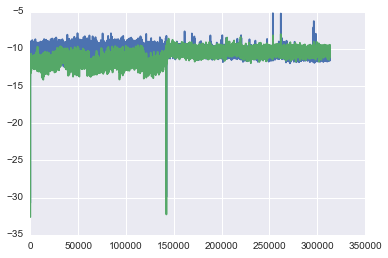

In [25]:
plt.plot(train['F2'])
plt.plot(train['F3'])

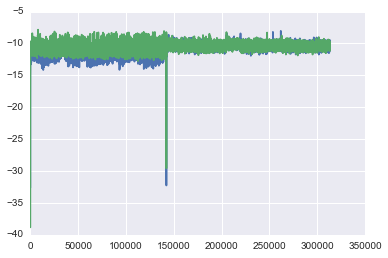

In [26]:
plt.plot(train['F3'])
plt.plot(train['F4'])

In [5]:
len(test_raw)

287869

In [6]:
print subjects

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [9]:
feat.shape

(4, 1422392)